# Notebook version of `README.md`

# caffe-oxford102

This bootstraps the training of deep convolutional neural networks with [Caffe](http://caffe.berkeleyvision.org/) to classify images in the [Oxford 102 category flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). The prototxt files for fine-tuning AlexNet and VGG_S models are included and use initial weights from training on the [ILSVRC 2012 (ImageNet) data](http://www.image-net.org/challenges/LSVRC/2012/). 

To download the Oxford 102 dataset, prepare Caffe image files, and download pre-trained model weights for AlexNet and VGG_S, run

```bash
python bootstrap.py
```
This will give you some pretty flower pictures:

![alt tag](plots/flowers.png)

The categories are split into training, testing, and validation sets. It seems odd that there are more testing images than training images.

![alt tag](plots/splits.png)

## AlexNet

This model is a [slightly modified](http://caffe.berkeleyvision.org/gathered/examples/imagenet.html) version of the [ILSVR 2012](http://www.image-net.org/challenges/LSVRC/2012/) winning [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks). The number of outputs in the inner product layer has been set to 102 to reflect the number of flower categories. Hyperparameter choices in `AlexNet/solver.prototxt` reflect those in [Fine-tuning CaffeNet for Style Recognition on “Flickr Style” Data](http://caffe.berkeleyvision.org/gathered/examples/finetune_flickr_style.html). The global learning rate is reduced while the learning rate for the final fully connected layer is increased relative to the other layers.

Once you've run the `bootstrap.py` script, you can begin training from this directory with:

```bash
cd AlexNet
$CAFFE_HOME/build/tools/caffe train -solver solver.prototxt -weights pretrained-weights.caffemodel -gpu 0
```

After 50,000 iterations, the top-1 error is 7% on the test set of 1,020 images:
```
I0215 15:28:06.417726  6585 solver.cpp:246] Iteration 50000, loss = 0.000120038
I0215 15:28:06.417789  6585 solver.cpp:264] Iteration 50000, Testing net (#0)
I0215 15:28:30.834987  6585 solver.cpp:315]     Test net output #0: accuracy = 0.9326
I0215 15:28:30.835072  6585 solver.cpp:251] Optimization Done.
I0215 15:28:30.835083  6585 caffe.cpp:121] Optimization Done.
```

The Caffe model can be downloaded at https://s3.amazonaws.com/jgoode/oxford102.caffemodel. You can also use the Caffe utility to download from its [gist](https://gist.github.com/jimgoo/0179e52305ca768a601f):

```bash
cd $CAFFE_HOME
./scripts/download_model_from_gist.sh 0179e52305ca768a601f <dirname>
```


## VGG-S

This is [another popular CNN](http://www.robots.ox.ac.uk/~vgg/research/deep_eval/) from the University of Oxford Visual Geometry Group (VGG). On ILSVRC 2012, it has a top-5 error rate of 13.1% compared to 15.3% for AlexNet.

Getting the prototxt file setup for training took a little more work because only the `deploy.prototxt` file was provided. I added the same learning rate multipliers for each layer as the AlexNet one and the same weight initialization schemes, although the latter was redundant when starting with pre-trained weights. The same random cropping and mirroring are also used. 

To train,

```bash
cd VGG_S
$CAFFE_HOME/build/tools/caffe train -solver solver.prototxt -weights pretrained-weights.caffemodel -gpu 0
```

After 14,500 iterations, this model does a little better with top-1 error of 5%. I stopped at 14,500 iterations because the loss had basically flat-lined:

```
I0917 13:26:48.291409 17111 solver.cpp:189] Iteration 14450, loss = 0.000572158
I0917 13:26:48.291549 17111 solver.cpp:464] Iteration 14450, lr = 0.001
I0917 13:27:52.307510 17111 solver.cpp:266] Iteration 14500, Testing net (#0)
I0917 13:28:50.950788 17111 solver.cpp:315]     Test net output #0: accuracy = 0.951129
```

AlexNet uses a crop size of 227 x 227, while VGG_S uses 224 x 224, so it's not an exact comparison.

## Notes

- The class labels for each species were deduced by Github user [m-co](https://github.com/m-co) and can be found in the file `class-labels.py`. They are in order from class 1 to class 102 as used in the mat files.

- These were run using the mean image for [ILSVRC 2012](http://www.image-net.org/challenges/LSVRC/2012/) instead of the mean for the actual Oxford dataset. This was more out of laziness that anything else.

- [This paper](http://arxiv.org/abs/1403.6382) reports 87% top-1 accuracy on the Oxford-102 dataset using an SVM on features from the [OverFeat model](http://cilvr.nyu.edu/doku.php?id=code:start). I couldn't tell which split they used for training.

## View some images

In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
from class_labels import labels

In [4]:
df_train = pd.read_csv('train.txt', sep=' ', header=None).rename(columns={0:'img', 1:'label'})
df_test = pd.read_csv('test.txt', sep=' ', header=None).rename(columns={0:'img', 1:'label'})
df_val = pd.read_csv('valid.txt', sep=' ', header=None).rename(columns={0:'img', 1:'label'})
df_all = pd.concat((df_train, df_test, df_val))

In [5]:
assert len(labels), len(df_all.label.unique())

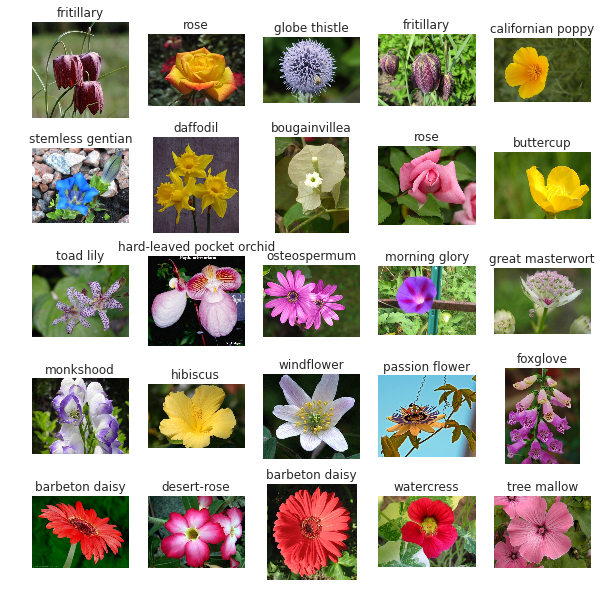

In [4]:
np.random.seed(0)
plt.figure(figsize=(10, 10))

for i, idx in enumerate(np.random.randint(0, len(df_all), 25)):
    row = df_all.iloc[idx,:]
    plt.subplot(5, 5, i+1)
    plt.imshow(Image.open(row.img));
    plt.axis('off')
    plt.grid('off')
    plt.title(labels[row.label])
plt.savefig('plots/flowers.png', bbox_inches='tight', pad_inches=0)    

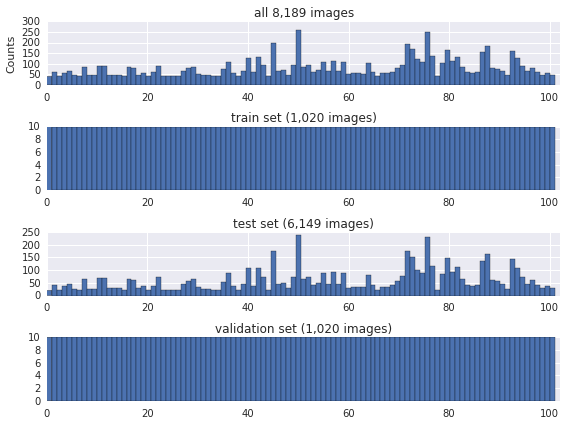

In [5]:
nb_bins = 102
y = df_all.label.values
y_train = df_train.label.values
y_test = df_test.label.values
y_val = df_val.label.values

fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(8,6))

ax1.hist(y, bins=nb_bins);
ax1.set_title('all {:,} images'.format(len(y)));
ax1.set_ylabel('Counts')
ax1.set_xlim([0, nb_bins])

ax2.hist(y_train, bins=nb_bins);
ax2.set_title('train set ({:,} images)'.format(len(y_train)));
ax2.set_xlim([0, nb_bins])

ax3.hist(y_test, bins=nb_bins);
ax3.set_title('test set ({:,} images)'.format(len(y_test)));
ax3.set_xlim([0, nb_bins])

ax4.hist(y_val, bins=nb_bins);
ax4.set_title('validation set ({:,} images)'.format(len(y_val)));
ax4.set_xlim([0, nb_bins])

plt.tight_layout()
plt.savefig('plots/splits.png', bbox_inches='tight', pad_inches=0)

In [2]:
import re

def read_caffe_log(log_file):
    with open(log_file, 'r') as f:
        p1 = re.compile('Iteration ([0-9]+), loss = (.*)')
        p2 = re.compile('accuracy = (.*)')
        it = 0
        loss = []
        acc = []
        for l in f:
            m = p1.search(l)
            if m is not None:
                it = int(m.group(1))
                train_loss = float(m.group(2))
                loss.append((it, train_loss))
            else:
                m = p2.search(l)
                if m is not None:
                    accuracy = float(m.group(1))
                    acc.append((it, accuracy))
    loss = pd.DataFrame(loss, columns=['iteration', 'train_loss']).set_index('iteration').tail(-1)
    acc = pd.DataFrame(acc, columns=['iteration', 'test_acc']).set_index('iteration').tail(-1)
    return loss, acc

In [13]:
loss_alex, acc_alex = read_caffe_log('AlexNet/log.txt')
loss_vgg, acc_vgg = read_caffe_log('VGG_S/log.txt')

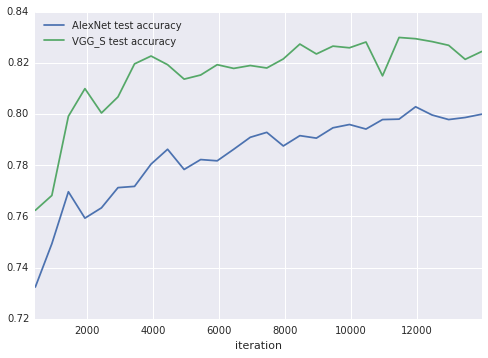

In [23]:
acc = acc_alex.rename(columns={'test_acc': 'AlexNet test accuracy'}).join(acc_vgg.rename(columns={'test_acc': 'VGG_S test accuracy'}))
acc[acc.index <= 14000].plot()
plt.savefig('plots/test_acc.png', bbox_inches='tight', pad_inches=0)

In [ ]:
loss_vgg, acc_vgg = read_caffe_log('VGG_S/log.txt')

In [21]:
acc

,AlexNet test accuracy,VGG_S test accuracy
iteration,,
450,0.732419,0.762419
950,0.749355,0.768226
1450,0.769677,0.799194
1950,0.759355,0.810000
2450,0.763387,0.800484
2950,0.771290,0.806774
3450,0.771774,0.819677
3950,0.780484,0.822742
4450,0.786290,0.819355
